In [1]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

import gensim.downloader as api
from nltk.corpus import stopwords

from gensim.models import KeyedVectors
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/troyjennings/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stopwords = stopwords.words('english')

# Data Loading

Import the featurized dataset and drop the unnecessary columns. Import word-vectors from the pretrained GLOVE model.

In [3]:
reviews_labeled = pd.read_csv('../data/interim/reviews_featurized.csv')
reviews_labeled.drop(labels=['clean_tokenized_review', 'lemma', 'sentiment'], axis=1, inplace=True)
reviews_labeled.sample(5)

,review_text,rating,n_tokens,lemma_sent,polarity,subjectivity,negative,neutral,positive,compound,target
11357,Really wanted to love this top but the proport...,2,14,really want love top proportion right body typ...,0.371429,0.458929,0.000,0.575,0.425,0.7984,0
1195,I initially purchased this shirt in the grey m...,5,27,initially purchase shirt grey motif color size...,0.177778,0.450000,0.063,0.500,0.437,0.9217,0
8118,"The fabric, so diaphanous! so flowy! the patte...",3,41,fabric diaphanous flowy pattern pretty interes...,0.035000,0.440000,0.000,0.814,0.186,0.8271,1
16098,"The suit is lovely, but it is very long in the...",2,39,suit lovely long torso gap leg tell run small ...,-0.034615,0.576923,0.154,0.544,0.302,0.8004,1
22584,What drew me to this shirt was the beautiful s...,2,43,draw shirt beautiful silver gold embroidery fr...,0.150000,0.596296,0.000,0.915,0.085,0.5994,1


In [4]:
# Import and load the pretrained Word2Vec model and the Google news 300 dataset.
if not os.path.exists('../data/interim/word2vec-google-news-300.wordvectors'):
    wv = api.load('word2vec-google-news-300')
    print('done loading word2vec, saving')
    wv.save('../data/interim/word2vec-google-news-300.wordvectors')
    print('wordvectors available at ../data/interim/word2vec-google-news-300.wordvectors')
else:
    print('wordvectors already available, not re-downloading')

# load the word2vec model
path_to_wordvectors = '../data/interim/word2vec-google-news-300.wordvectors'
glove_w2v_model = KeyedVectors.load(path_to_wordvectors)
print(f'done loading Word2Vec as {type(glove_w2v_model)}')

wordvectors already available, not re-downloading
done loading Word2Vec as <class 'gensim.models.keyedvectors.KeyedVectors'>


# Helper Functions

In [5]:
def embedding_feats(document): 
    '''
    Calcualtes a word-2-vector matrix for an individual document.

    Parameters
    ----------
    document : str      
        The lemma from a review test.

    Returns
    -------
    feat
        The featurized vector for the document.
    '''
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)

    feat_for_this =  np.zeros(DIMENSION) # create a zero-vector of length DIMENSION
    count_for_this = 0 + 1e-5 # to avoid divide-by-zero 

    for token in document.split(' '):
        if token in glove_w2v_model:
            feat_for_this += glove_w2v_model[token]
            count_for_this += 1
    if count_for_this != 0:
        feat = feat_for_this / count_for_this
    else:
        feat = zero_vector
    return feat

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    

def run_experiment(X, preprocessor, output_path):
    '''
    Runs a classification experiment using a predefined word vectorizer. Outputs a confusion matrix plot
    to an output directory.

    Parameters
    ----------
    X : DataFram
        The training data on which to run the experiment.
    preprocessor : Transformer
        An sklearn word vectorizer.
    output_path : str
        The output path sub-directory to export to.
    '''
    for model in models.items():
        pipe = Pipeline([
            ('preproc', preprocessor),
            ('clf', model[1])
        ])

        # print classification reports
        y_pred = cross_val_predict(pipe, X, y_train)
        print(f'Classification Report : {model[0]}\n')
        print('-------------------------------------')
        print(classification_report(y_train, y_pred, target_names=TARGETS))

        # print confusion matrices
        print(f'Confusion Matrix : {model[0]}\n')
        print('-------------------------------------')
        plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes=TARGETS, normalize=True, title=f'Confusion Matrix : {model[0]}')
        plt.grid(False)
        plt.savefig(f'../assets/{output_path}/bow_{model[0].replace(" ", "_").lower()}.png')
        plt.show()

# Data Preprocessing

In [6]:
# preprocessing pipeline
SCALING_COLS = ['n_tokens', 'polarity', 'subjectivity', 'compound', 'rating']
SCALED_NAMES = ['t_n_tokens', 't_polarity', 't_subjectivity', 't_compound', 't_rating']

column_trans = ColumnTransformer([
    ('scaler', MinMaxScaler(), SCALING_COLS),
], verbose_feature_names_out=True)

column_trans.fit(reviews_labeled)
trans = column_trans.transform(reviews_labeled)
transformed = pd.DataFrame(trans, columns=SCALED_NAMES)

# append transformed columns to the dataset and drop the old columns
reviews_labeled = pd.concat([reviews_labeled, transformed], axis=1)
reviews_labeled.drop(labels=SCALING_COLS, axis=1, inplace=True)

# create w2v vectors
reviews_feats = reviews_labeled['lemma_sent'].apply(lambda r: embedding_feats(r)) 
reviews_labeled.insert(len(reviews_labeled.columns), 'w2v_feat', reviews_feats)
reviews_labeled.sample(5)

,review_text,lemma_sent,negative,neutral,positive,target,t_n_tokens,t_polarity,t_subjectivity,t_compound,t_rating,w2v_feat
6410,I love this jacket. i have worn it twice and g...,love jacket wear twice get compliment time det...,0.000,0.513,0.487,0,0.517857,0.661310,0.585714,0.987645,1.0,"[-0.016005955764941827, 0.030785105298194067, ..."
14349,I bought this top for my sister's birthday so ...,buy top sisters birthday review base opinion l...,0.000,0.632,0.368,0,0.321429,0.631250,0.775000,0.936366,1.0,"[-0.04366420656242418, -0.056039881072759964, ..."
20152,"Tts. i'm 38c, 8-10 and m fits just right. nice...",tts c fit right nice fit top flowy skirt get c...,0.000,0.367,0.633,0,0.214286,0.723810,0.572619,0.958749,1.0,"[-0.047320989741065585, 0.006281921249483654, ..."
16242,After reading the previous reviews i thought s...,read previous review think size would great id...,0.113,0.624,0.263,1,0.750000,0.480758,0.514242,0.917757,0.0,"[0.0051576469314520215, 0.04674830569352629, -..."
19723,"Maeve once again created another beauty! love,...",maeve create another beauty love love love pur...,0.000,0.426,0.574,0,0.357143,0.611111,0.477778,0.987284,1.0,"[0.029452499922187538, -0.04587400050049975, -..."


# Modeling

## Data Partitioning

In [7]:
X = reviews_labeled.drop(labels='target', axis=1)
y = reviews_labeled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15848, 11) (6793, 11) (15848,) (6793,)


In [8]:
# save the preprocessed data for the distributional tests, hyperparameter tuning, and error analysis to avoid data leakage
pd.concat([X_train, y_train], axis=1).to_csv('../data/final/train.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('../data/final/test.csv', index=False)

In [9]:
# drop unnesseary features for the bow-based and embedding-based models, respectively
X_train.drop(labels=['review_text', 'w2v_feat'], axis=1, inplace=True)
X_train_text_only = X_train.drop(labels=['t_subjectivity', 'negative', 'positive', 'neutral', 't_n_tokens', 't_polarity', 't_compound', 't_rating'], axis=1)
X_train_text_and_rating = X_train.drop(labels=['t_subjectivity', 'negative', 'positive', 'neutral', 't_n_tokens', 't_polarity', 't_compound'], axis=1)

In [10]:
# verify columns
print(X_train_text_only.columns)
print(X_train_text_and_rating.columns)
print(X_train.columns)

Index(['lemma_sent'], dtype='object')
Index(['lemma_sent', 't_rating'], dtype='object')
Index(['lemma_sent', 'negative', 'neutral', 'positive', 't_n_tokens',
       't_polarity', 't_subjectivity', 't_compound', 't_rating'],
      dtype='object')


In [11]:
# define the preprocessor pipelines
MAX_FEAT = 5000 # maximum features from the word vector representation
TARGETS = ['recommended', 'not-recommended']

# word-based preprocessors
bow_preproc = ColumnTransformer([('vectorizer', CountVectorizer(max_features=MAX_FEAT), 'lemma_sent')])
n_grams_preproc = ColumnTransformer([('vectorizer', CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3)), 'lemma_sent')])
tfidf_preproc = ColumnTransformer([('vectorizer', TfidfVectorizer(max_features=MAX_FEAT), 'lemma_sent')])

# define models
log_reg_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rand_frst_base = RandomForestClassifier(random_state=42)
svm_base = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
models = {
    'Logistic Regression': log_reg_base, 
    'Random Forest': rand_frst_base, 
    'Support Vector Machine': svm_base
}

## Bag-of-Word Models

### Text-Only

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.75      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


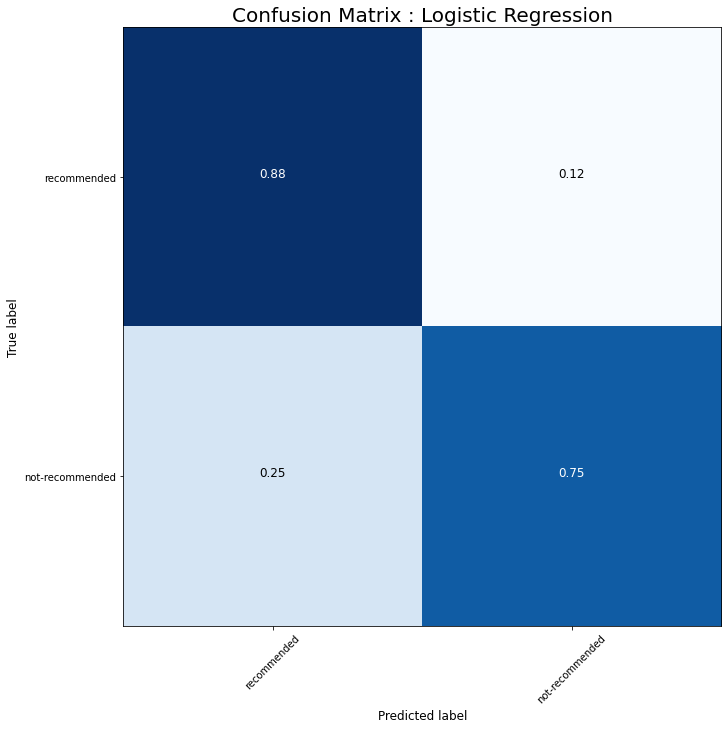

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.92     12994
not-recommended       0.87      0.20      0.33      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.60      0.62     15848
   weighted avg       0.85      0.85      0.81     15848

Confusion Matrix : Random Forest

-------------------------------------


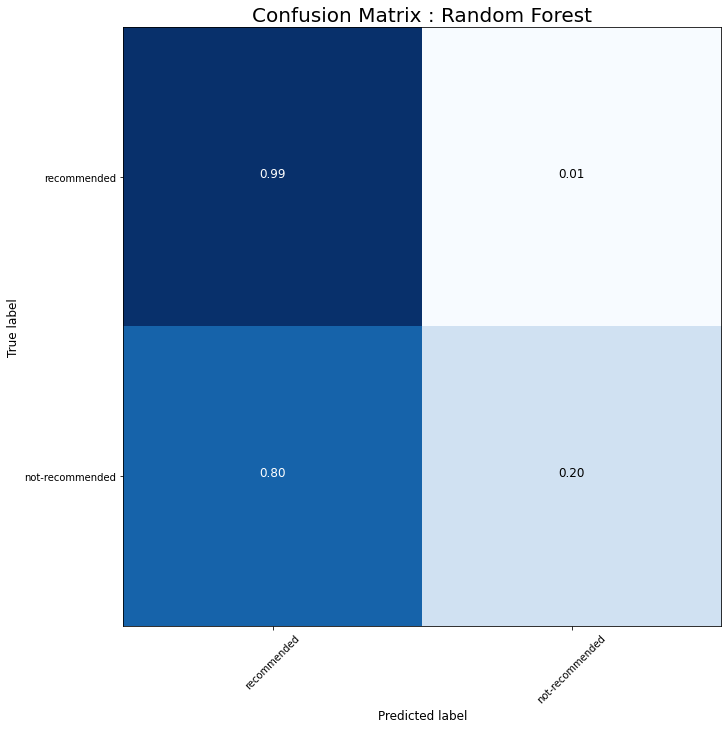

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.93      0.89      0.91     12994
not-recommended       0.57      0.68      0.62      2854

       accuracy                           0.85     15848
      macro avg       0.75      0.78      0.76     15848
   weighted avg       0.86      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


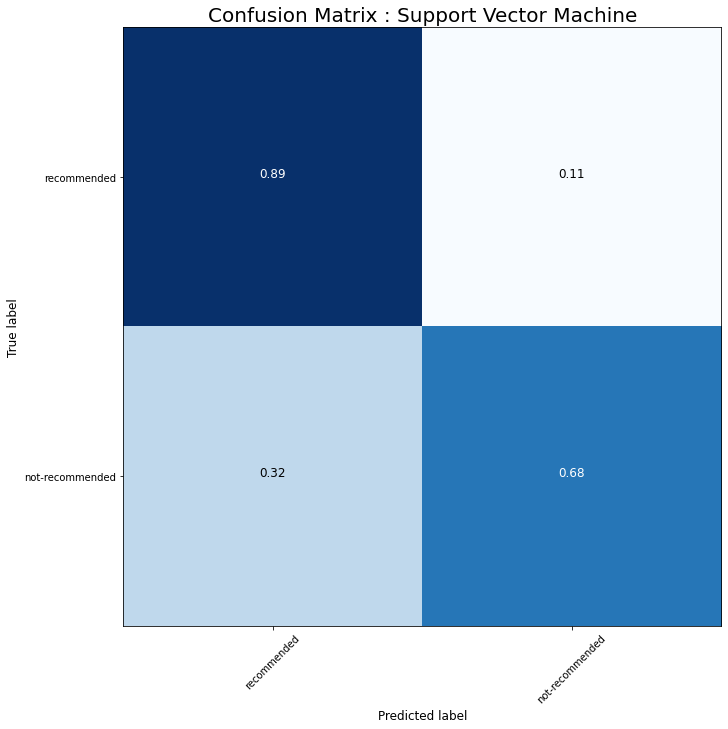

In [12]:
run_experiment(X=X_train_text_only, preprocessor=bow_preproc, output_path='text-only')

### Text and Rating

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.75      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


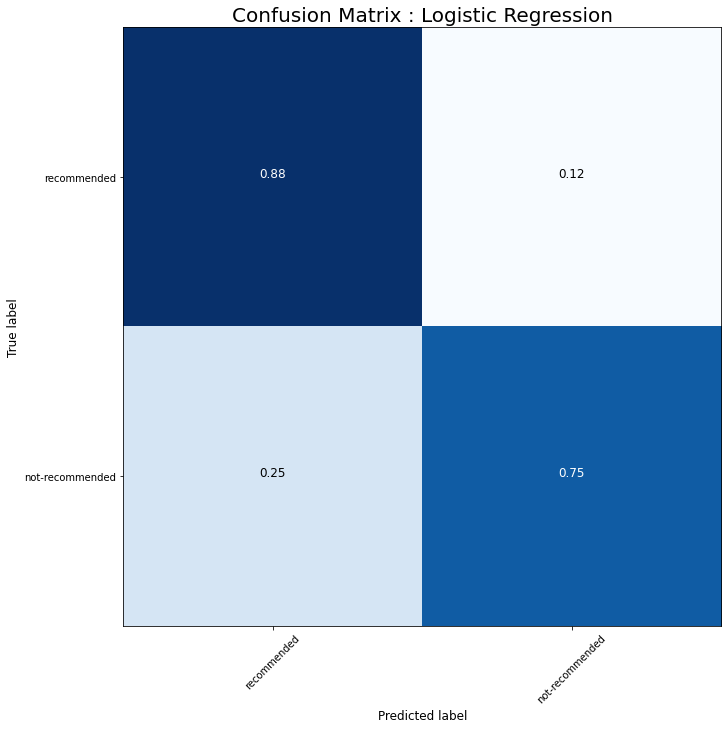

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.92     12994
not-recommended       0.87      0.20      0.33      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.60      0.62     15848
   weighted avg       0.85      0.85      0.81     15848

Confusion Matrix : Random Forest

-------------------------------------


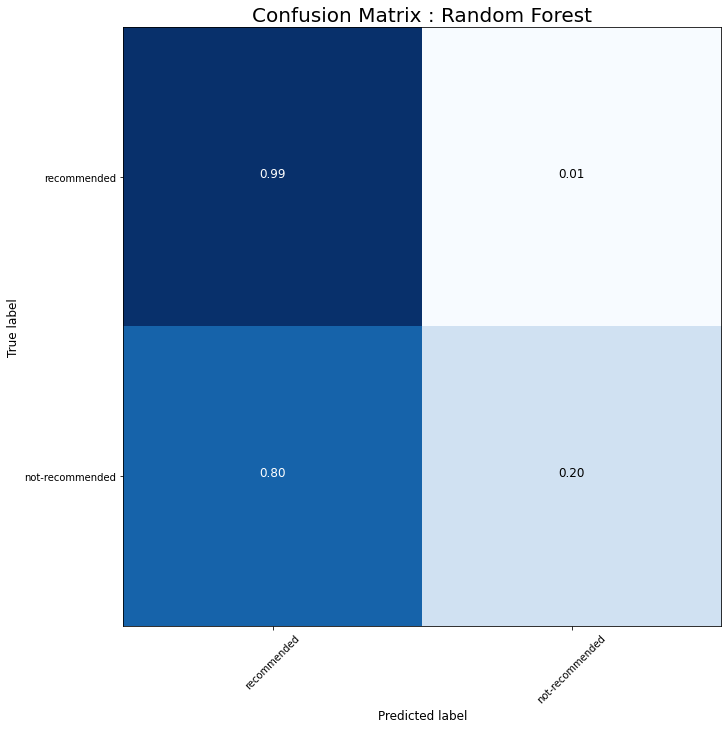

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.93      0.89      0.91     12994
not-recommended       0.57      0.68      0.62      2854

       accuracy                           0.85     15848
      macro avg       0.75      0.78      0.76     15848
   weighted avg       0.86      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


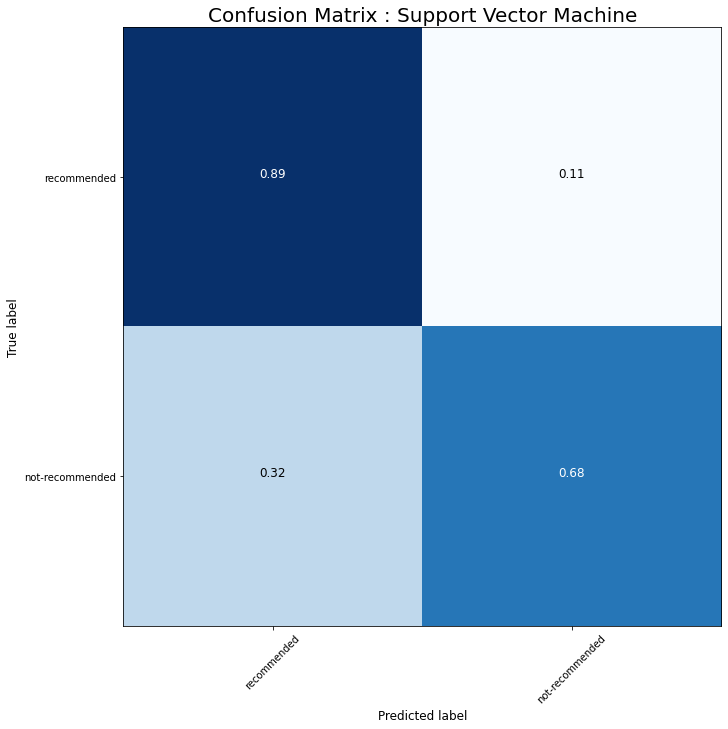

In [13]:
run_experiment(X=X_train_text_and_rating, preprocessor=bow_preproc, output_path='text-and-rating')

### All Features

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.75      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


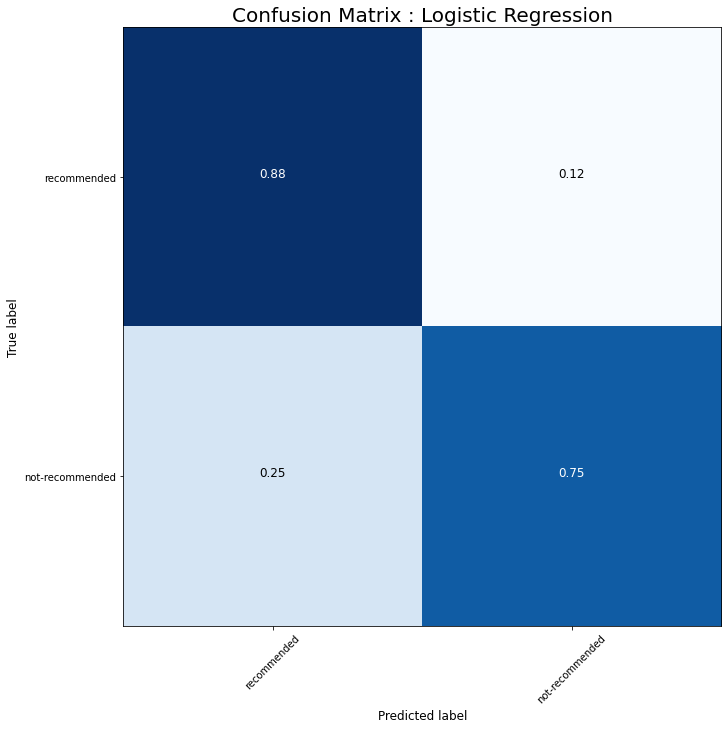

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.92     12994
not-recommended       0.87      0.20      0.33      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.60      0.62     15848
   weighted avg       0.85      0.85      0.81     15848

Confusion Matrix : Random Forest

-------------------------------------


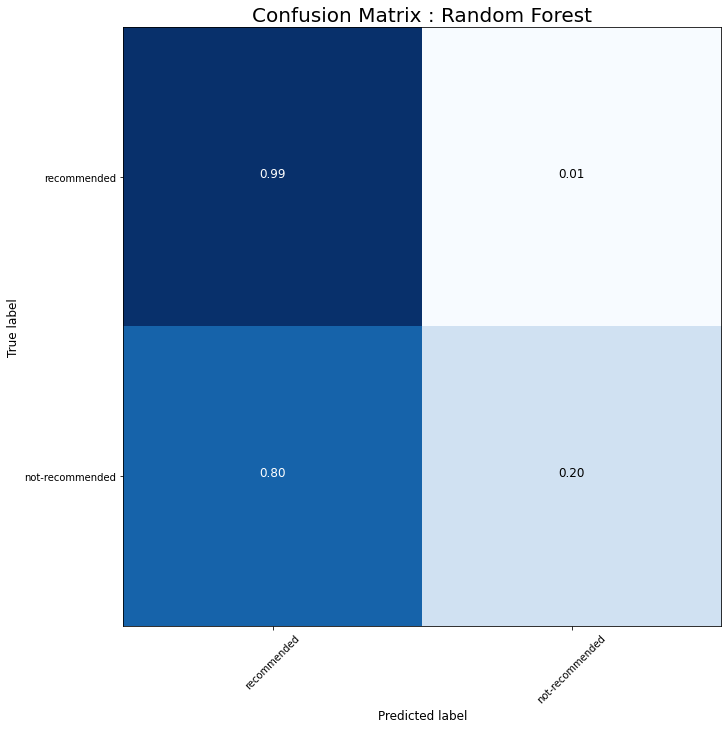

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.93      0.89      0.91     12994
not-recommended       0.57      0.68      0.62      2854

       accuracy                           0.85     15848
      macro avg       0.75      0.78      0.76     15848
   weighted avg       0.86      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


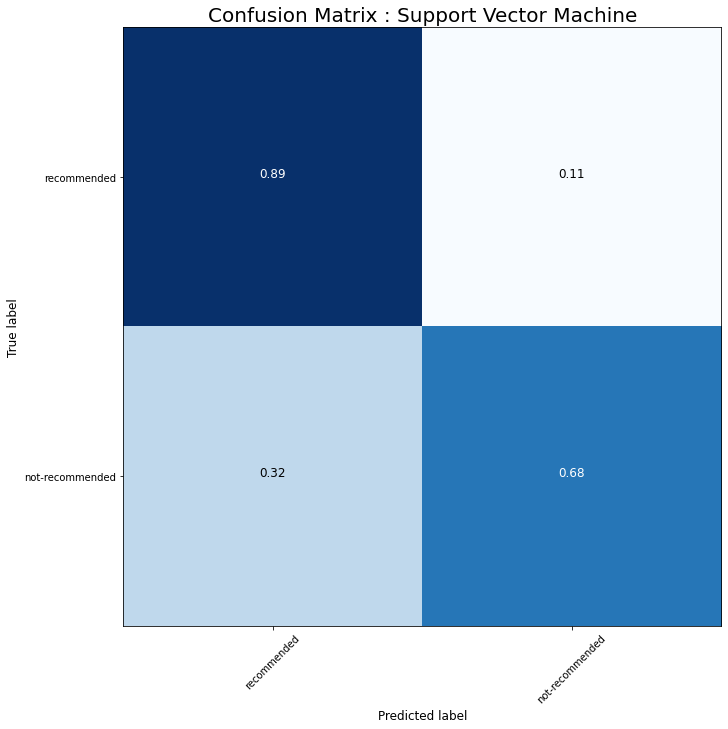

In [14]:
run_experiment(X=X_train, preprocessor=bow_preproc, output_path='all-features')

## Bag-of-N-Grams Models

### Text-Only

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.90      0.92     12994
not-recommended       0.60      0.72      0.65      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.81      0.79     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


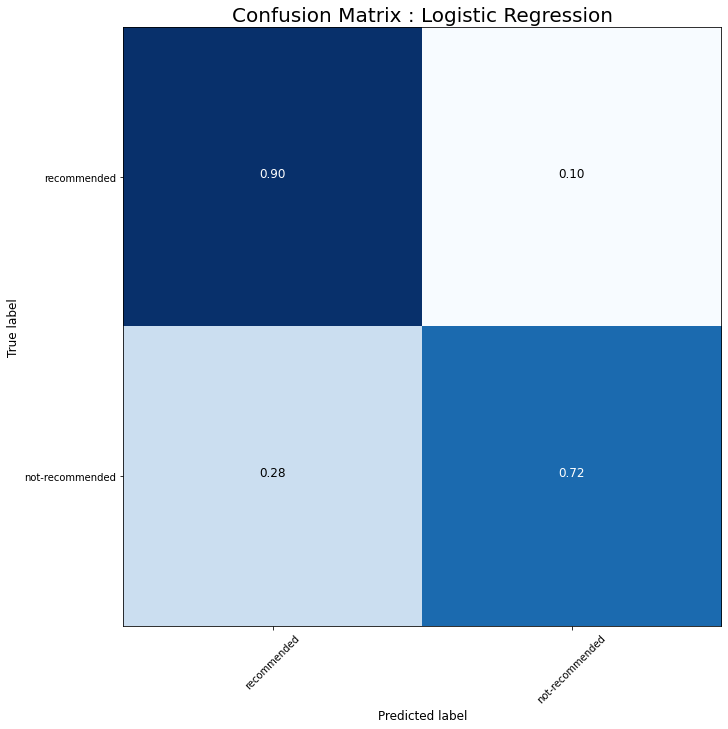

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.83      0.29      0.43      2854

       accuracy                           0.86     15848
      macro avg       0.85      0.64      0.68     15848
   weighted avg       0.86      0.86      0.83     15848

Confusion Matrix : Random Forest

-------------------------------------


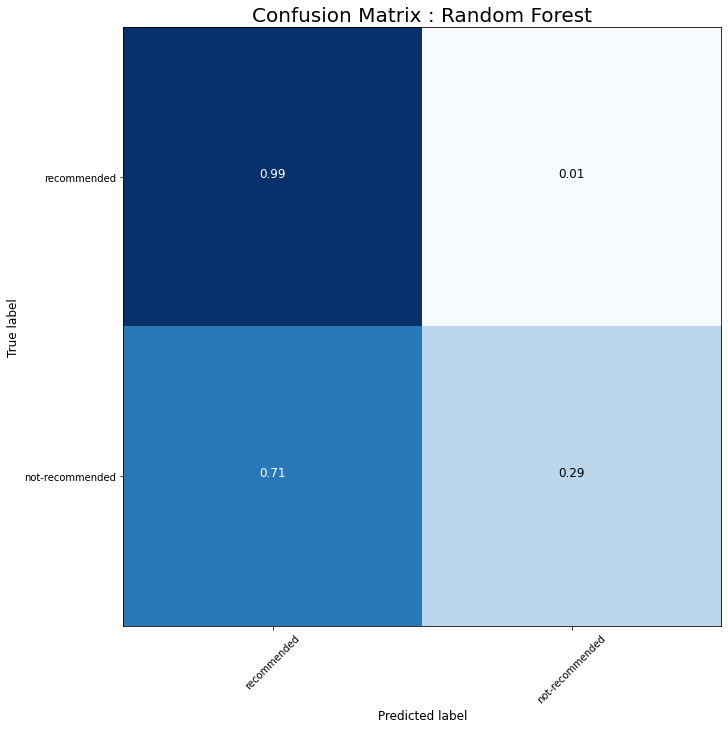

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.92      0.89      0.91     12994
not-recommended       0.57      0.63      0.60      2854

       accuracy                           0.85     15848
      macro avg       0.74      0.76      0.75     15848
   weighted avg       0.85      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


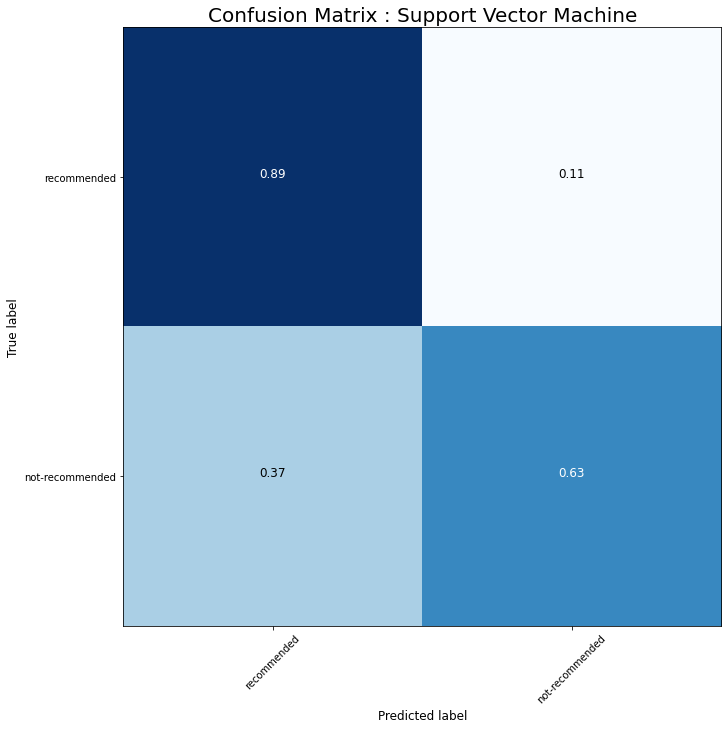

In [15]:
run_experiment(X=X_train_text_only, preprocessor=n_grams_preproc, output_path='text-only')

### Text & Rating

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.90      0.92     12994
not-recommended       0.60      0.72      0.65      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.81      0.79     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


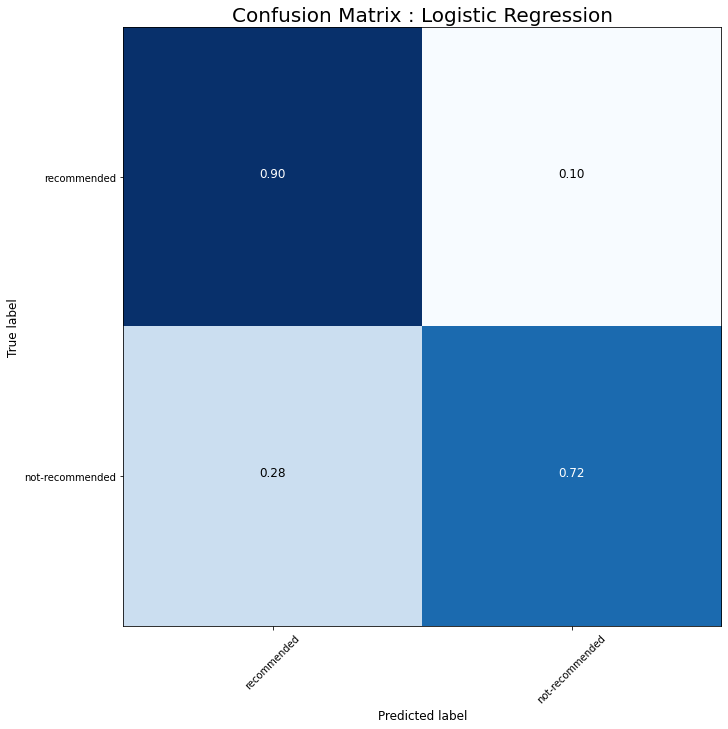

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.83      0.29      0.43      2854

       accuracy                           0.86     15848
      macro avg       0.85      0.64      0.68     15848
   weighted avg       0.86      0.86      0.83     15848

Confusion Matrix : Random Forest

-------------------------------------


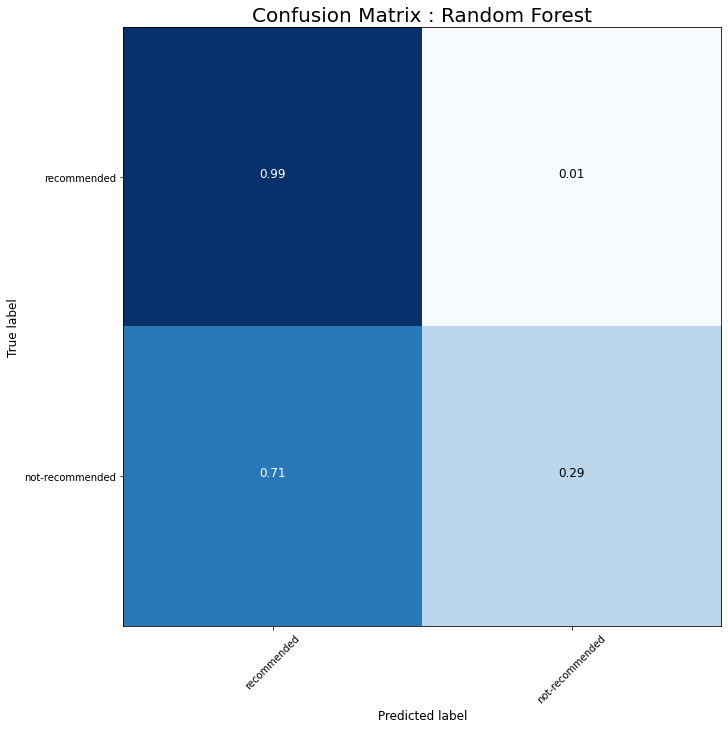

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.92      0.89      0.91     12994
not-recommended       0.57      0.63      0.60      2854

       accuracy                           0.85     15848
      macro avg       0.74      0.76      0.75     15848
   weighted avg       0.85      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


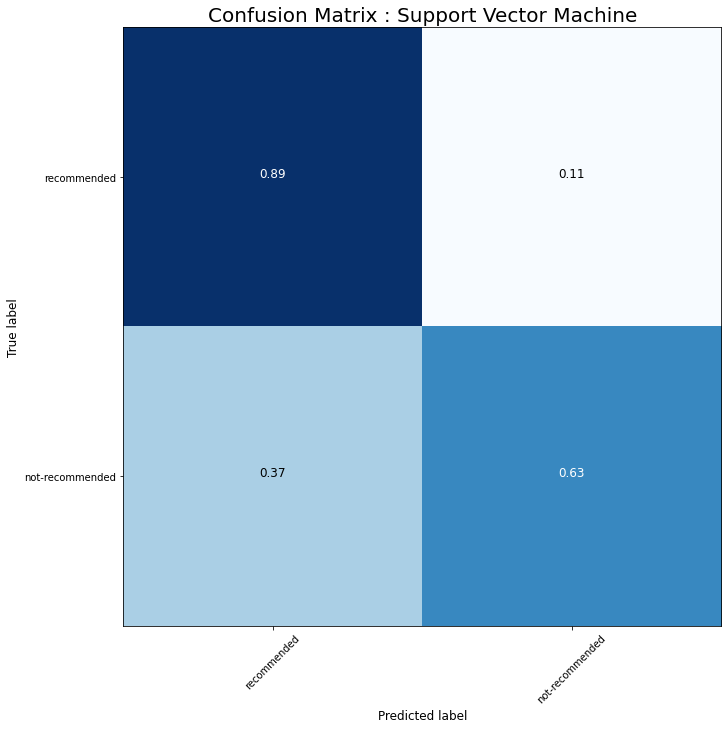

In [16]:
run_experiment(X=X_train_text_and_rating, preprocessor=n_grams_preproc, output_path='text-and-rating')

### All Features

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.90      0.92     12994
not-recommended       0.60      0.72      0.65      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.81      0.79     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


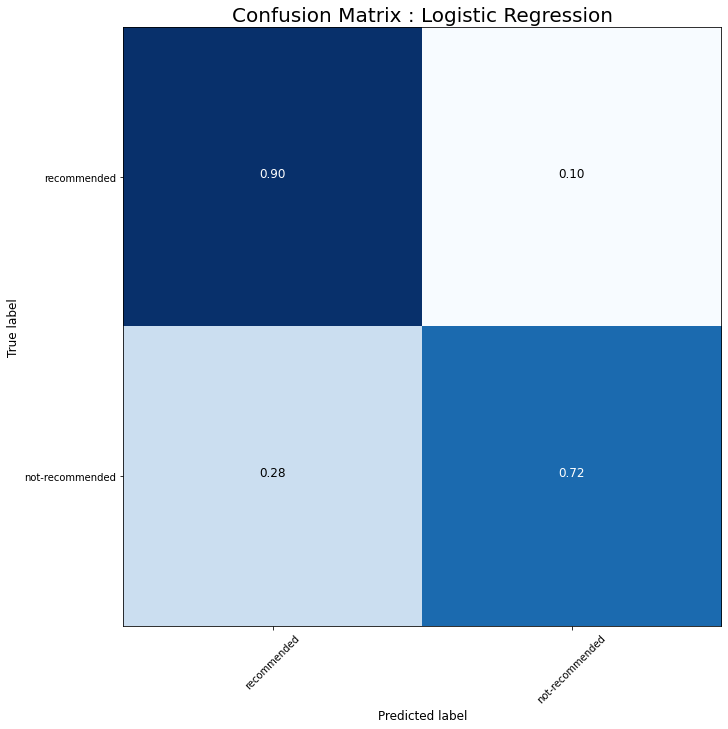

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.83      0.29      0.43      2854

       accuracy                           0.86     15848
      macro avg       0.85      0.64      0.68     15848
   weighted avg       0.86      0.86      0.83     15848

Confusion Matrix : Random Forest

-------------------------------------


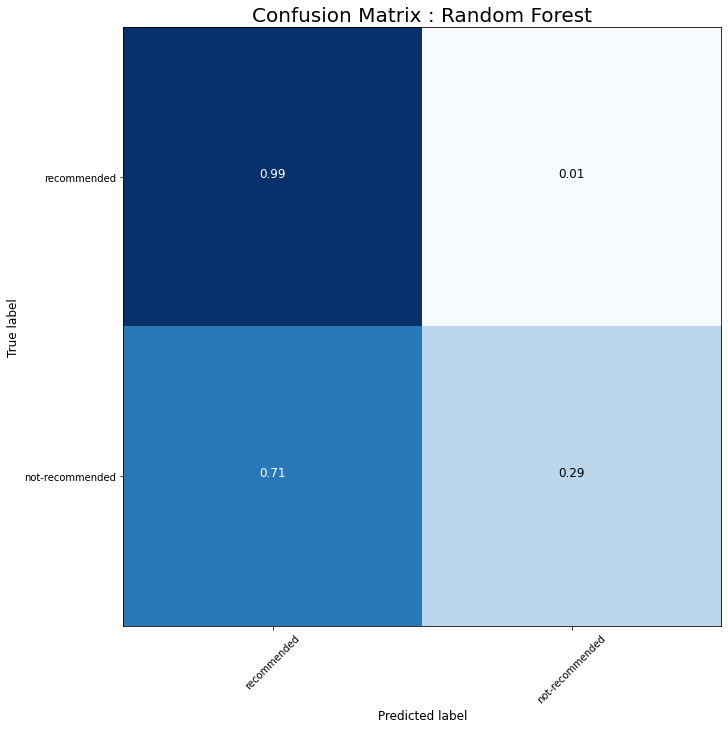

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.92      0.89      0.91     12994
not-recommended       0.57      0.63      0.60      2854

       accuracy                           0.85     15848
      macro avg       0.74      0.76      0.75     15848
   weighted avg       0.85      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


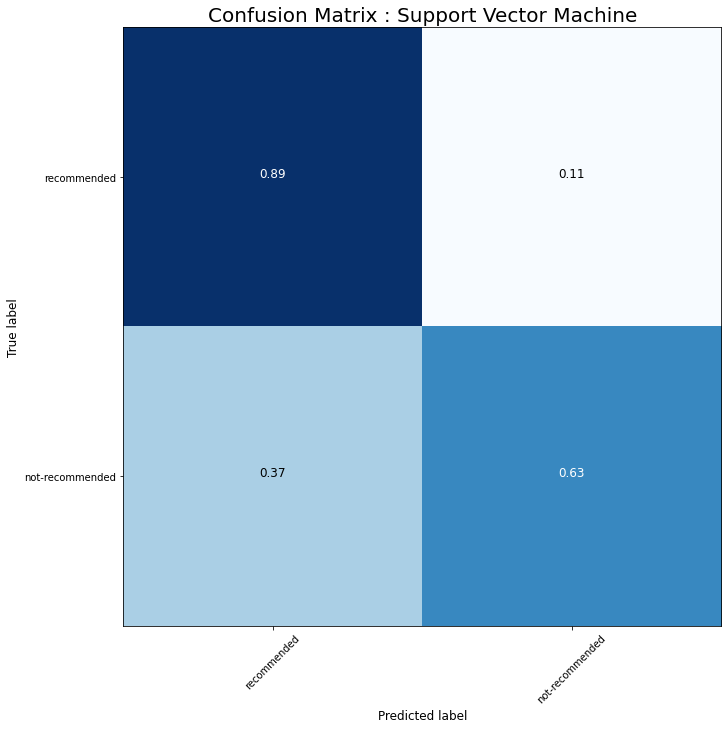

In [17]:
run_experiment(X=X_train, preprocessor=n_grams_preproc, output_path='all-features')

## TF-IDF Models

### Text-Only

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.87      0.91     12994
not-recommended       0.57      0.82      0.68      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.85      0.79     15848
   weighted avg       0.89      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


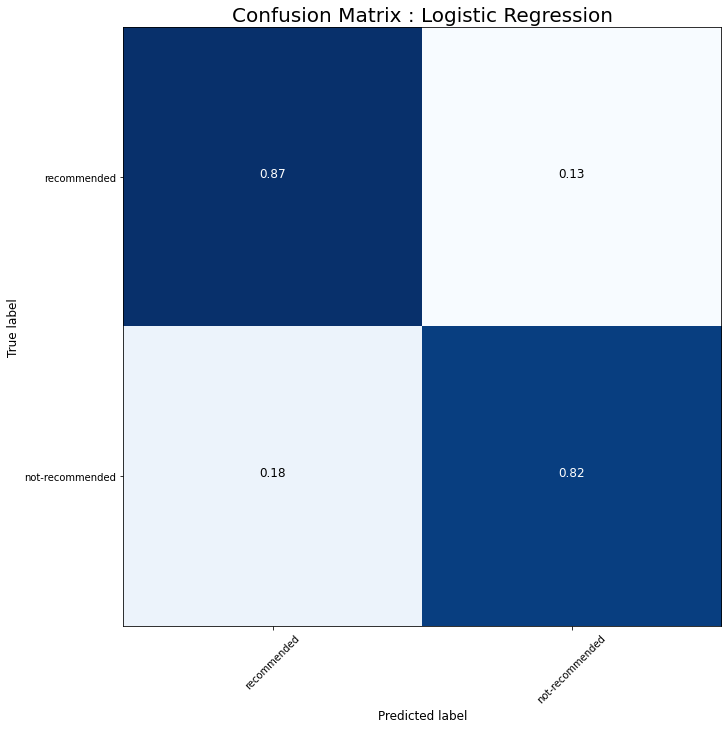

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.91     12994
not-recommended       0.87      0.18      0.30      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.59      0.61     15848
   weighted avg       0.85      0.85      0.80     15848

Confusion Matrix : Random Forest

-------------------------------------


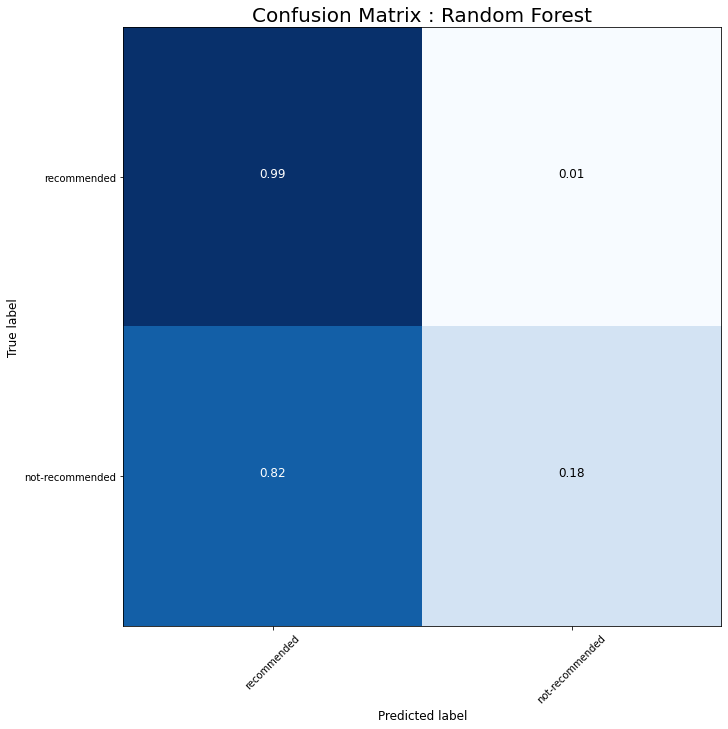

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.76      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.86     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


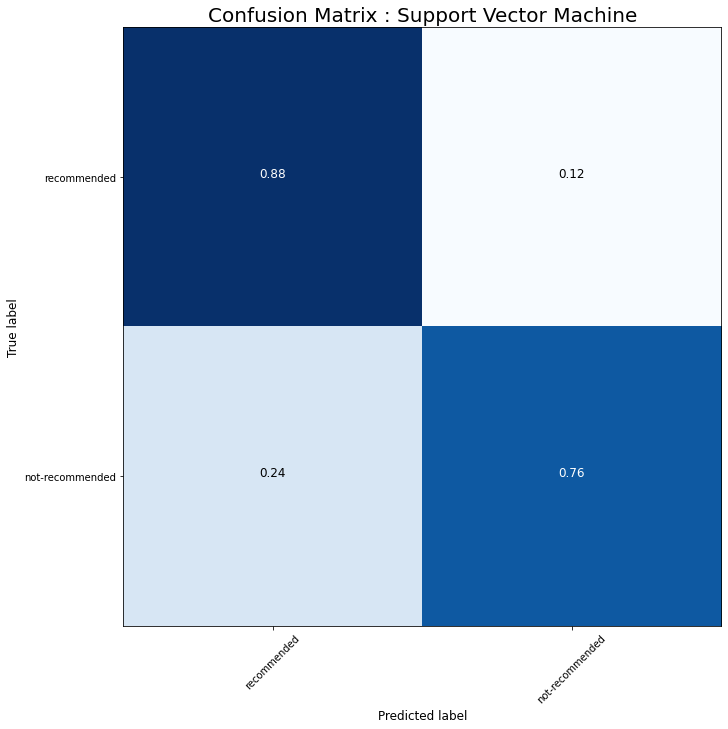

In [18]:
run_experiment(X=X_train_text_only, preprocessor=tfidf_preproc, output_path='text-only')

### Text & Rating

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.87      0.91     12994
not-recommended       0.57      0.82      0.68      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.85      0.79     15848
   weighted avg       0.89      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


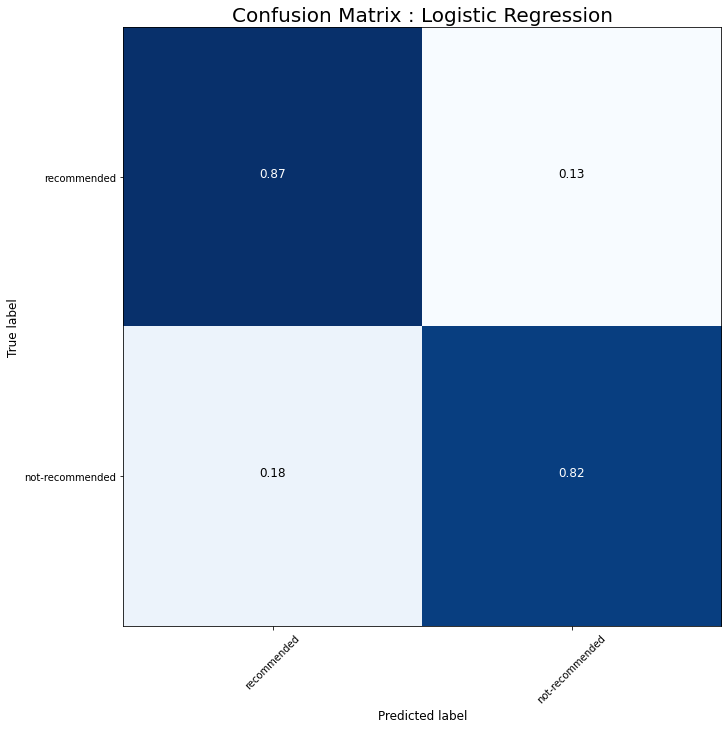

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.91     12994
not-recommended       0.87      0.18      0.30      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.59      0.61     15848
   weighted avg       0.85      0.85      0.80     15848

Confusion Matrix : Random Forest

-------------------------------------


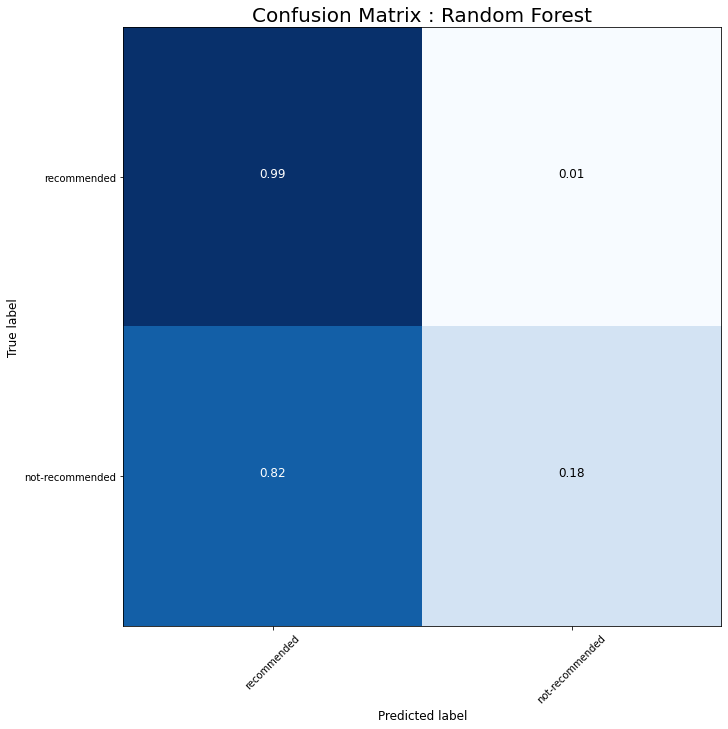

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.76      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.86     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


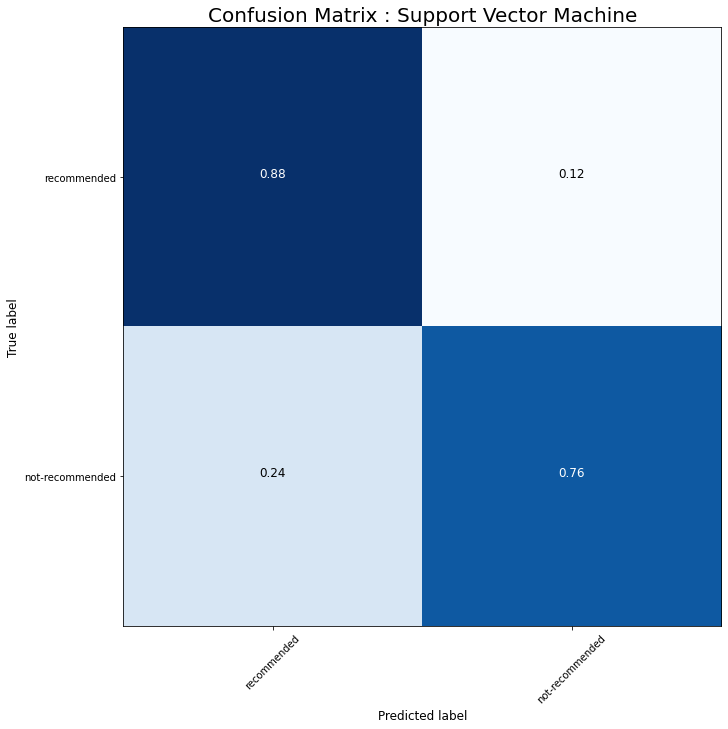

In [19]:
run_experiment(X=X_train_text_and_rating, preprocessor=tfidf_preproc, output_path='text-and-rating')

### All Features

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.87      0.91     12994
not-recommended       0.57      0.82      0.68      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.85      0.79     15848
   weighted avg       0.89      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


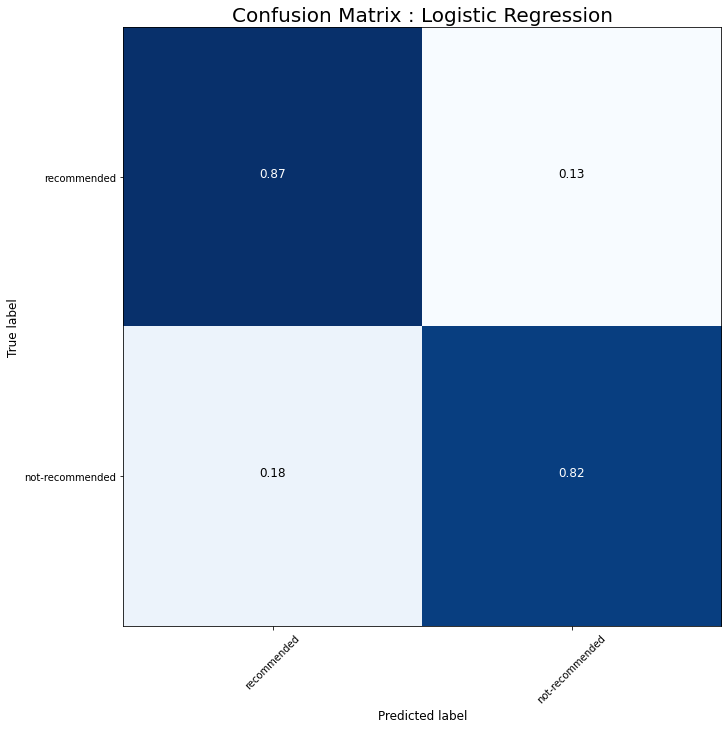

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.99      0.91     12994
not-recommended       0.87      0.18      0.30      2854

       accuracy                           0.85     15848
      macro avg       0.86      0.59      0.61     15848
   weighted avg       0.85      0.85      0.80     15848

Confusion Matrix : Random Forest

-------------------------------------


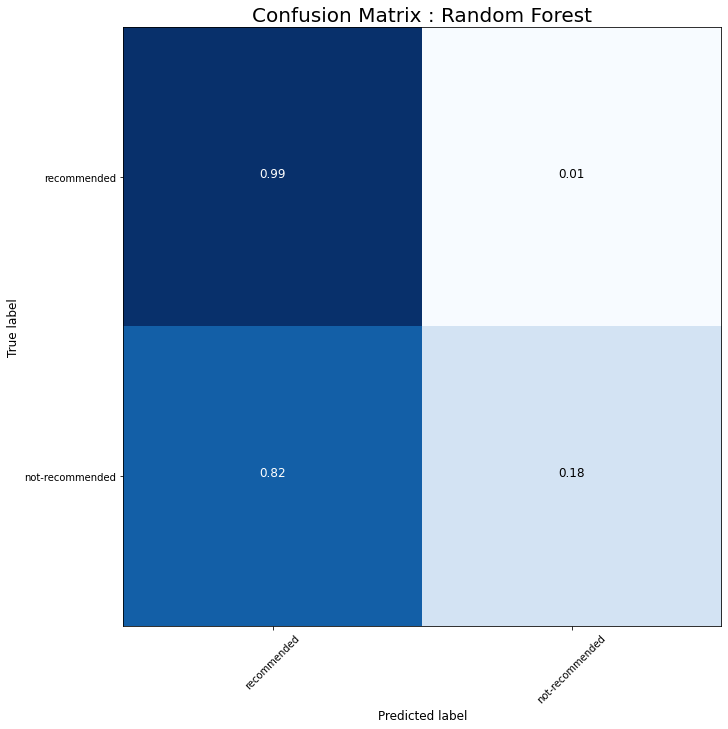

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.76      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.86     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


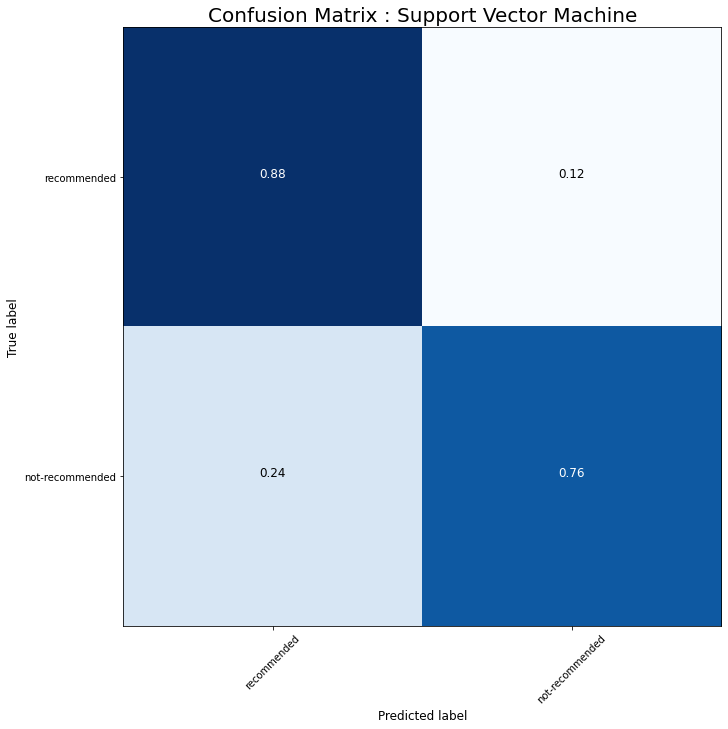

In [20]:
run_experiment(X=X_train, preprocessor=tfidf_preproc, output_path='all-features')